In [37]:
from PIL import Image

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import cv2

In [142]:
# GPU 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## 파일 읽어오기

In [3]:
pathes = []

for dirpath, dirnames, filenames in os.walk('data/tourist_spot'):
    for filename in filenames:
        file_path = dirpath + '/' + filename
        pathes.append(file_path)
        


In [5]:
pathes[0]

'data/tourist_spot/150년 수령 느티나무.png'

## 데이터셋 생성

In [146]:
from torch.utils.data import Dataset
import torchvision.transforms as T


transforms = T.Compose([T.ToTensor(),
                       T.Resize((512,512))])
main_dir = 'data/tourist_spot'


class TouristSpotDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")


        if self.transform is not None:
            image = self.transform(image)

        return image, image

In [147]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

full_dataset = FolderDataset(main_dir, transforms)
train_dataset, val_dataset = random_split(full_dataset, [int(len(full_dataset)*0.8), int(len(full_dataset)*0.2)+1]) 

train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [148]:
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=32)

In [149]:
img1, img2 = next(iter(full_loader))

(-0.5, 511.5, 511.5, -0.5)

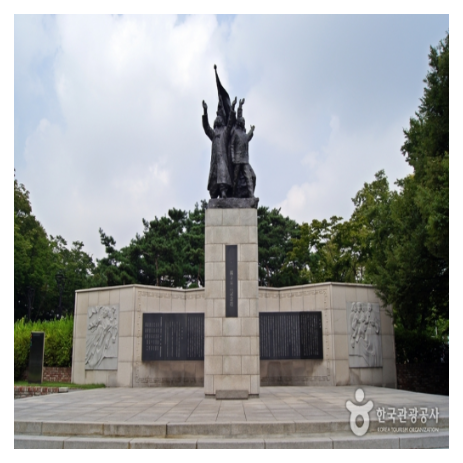

In [150]:
plt.imshow(np.transpose(img2[1].numpy(), (1,2,0)))
plt.axis('off')

## 모델 정의

In [151]:
from torch import nn 
from torch.nn import Conv2d, ReLU, MaxPool2d, ConvTranspose2d



class ConvEncoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))

        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        
        return x

In [152]:
class ConvDecoder(nn.Module):
    """
    A simple Convolutional Decoder Model
    """

    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, x):
         # Upscale the image with convtranspose etc.
        x = self.deconv1(x)
        x = self.relu1(x)

        x = self.deconv2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.relu3(x)

        x = self.deconv4(x)
        x = self.relu4(x)

        x = self.deconv5(x)
        x = self.relu5(x)
        return x

In [153]:
from torch import optim


loss_fn = nn.MSELoss() # We use Mean squared loss which computes difference between two images.

encoder = ConvEncoder() # Our encoder model
decoder = ConvDecoder() # Our decoder model

# Shift models to GPU
encoder.to(device)
decoder.to(device)

# Both the enocder and decoder parameters
autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(autoencoder_params, lr=1e-3) # Adam Optimizer

# Time to Train !!!
EPOCHS = 10
# Usual Training Loop
for epoch in tqdm(range(EPOCHS)):
        train_loss = train_step(encoder, decoder, train_loader, loss_fn, optimizer, device=device)
        
        print(f"Epochs = {epoch}, Training Loss : {train_loss}")
        
        val_loss = val_step(encoder, decoder, val_loader, loss_fn, device=device)
        
        print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

        # Simple Best Model saving
#         if val_loss < max_loss:
#             print("Validation Loss decreased, saving new best model")
#             torch.save(encoder.state_dict(), "encoder_model.pt")
#             torch.save(decoder.state_dict(), "decoder_model.pt")

# Save the feature representations.
EMBEDDING_SHAPE = (3, 256, 16, 16) # This we know from our encoder

# We need feature representations for complete dataset not just train and validation.
# Hence we use full loader here.
embedding = create_embedding(encoder, full_loader, EMBEDDING_SHAPE, device)

# Convert embedding to numpy and save them
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]

# Save the embeddings for complete dataset, not just train
flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save("data_embedding.npy", flattened_embedding)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epochs = 0, Training Loss : 0.14220552146434784


 10%|████████▎                                                                          | 1/10 [00:13<02:00, 13.43s/it]

Epochs = 0, Validation Loss : 0.13787926733493805
Epochs = 1, Training Loss : 0.07320941984653473


 20%|████████████████▌                                                                  | 2/10 [00:26<01:46, 13.36s/it]

Epochs = 1, Validation Loss : 0.07330667227506638
Epochs = 2, Training Loss : 0.05452495813369751


 30%|████████████████████████▉                                                          | 3/10 [00:39<01:33, 13.31s/it]

Epochs = 2, Validation Loss : 0.05655428022146225
Epochs = 3, Training Loss : 0.03882169723510742


 40%|█████████████████████████████████▏                                                 | 4/10 [00:53<01:19, 13.27s/it]

Epochs = 3, Validation Loss : 0.041145868599414825
Epochs = 4, Training Loss : 0.02975218929350376


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:06<01:06, 13.25s/it]

Epochs = 4, Validation Loss : 0.03202460706233978
Epochs = 5, Training Loss : 0.024899087846279144


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:19<00:52, 13.22s/it]

Epochs = 5, Validation Loss : 0.026605021208524704
Epochs = 6, Training Loss : 0.023053621873259544


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:32<00:39, 13.21s/it]

Epochs = 6, Validation Loss : 0.02493484504520893
Epochs = 7, Training Loss : 0.021466325968503952


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:45<00:26, 13.19s/it]

Epochs = 7, Validation Loss : 0.02383236214518547
Epochs = 8, Training Loss : 0.02035239152610302


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:58<00:13, 13.18s/it]

Epochs = 8, Validation Loss : 0.022071728482842445
Epochs = 9, Training Loss : 0.020036567002534866


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.20s/it]

Epochs = 9, Validation Loss : 0.021247874945402145


In [154]:

def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    train_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    optimizer: PyTorch optimizer.
    device: "cuda" or "cpu"
    Returns: Train Loss
    """
    #  Set networks to train mode.
    encoder.train()
    decoder.train()

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        # Move images to device
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        # Zero grad the optimizer
        optimizer.zero_grad()
        # Feed the train images to encoder
        enc_output = encoder(train_img)
        # The output of encoder is input to decoder !
        dec_output = decoder(enc_output)
        
        # Decoder output is reconstructed image
        # Compute loss with it and orginal image which is target image.
        loss = loss_fn(dec_output, target_img)
        # Backpropogate
        loss.backward()
        # Apply the optimizer to network by calling step.
        optimizer.step()
    # Return the loss
    return loss.item()

def val_step(encoder, decoder, val_loader, loss_fn, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    val_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    device: "cuda" or "cpu"
    Returns: Validation Loss
    """
    
    # Set to eval mode.
    encoder.eval()
    decoder.eval()
    
    # We don't need to compute gradients while validating.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            # Move to device
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # Again as train. Feed encoder the train image.
            enc_output = encoder(train_img)
            # Decoder takes encoder output and reconstructs the image.
            dec_output = decoder(enc_output)

            # Validation loss for encoder and decoder.
            loss = loss_fn(dec_output, target_img)
    # Return the loss
    return loss.item()

In [155]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    """
    Creates embedding using encoder from dataloader.
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
    embedding_dim: Tuple (c, h, w) Dimension of embedding = output of encoder dimesntions.
    device: "cuda" or "cpu"
    Returns: Embedding of size (num_images_in_loader + 1, c, h, w)
    """
    # Set encoder to eval mode.
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim)
    
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            # We can compute this on GPU. be faster
            train_img = train_img.to(device)
            
            # Get encoder outputs and move outputs to cpu
            enc_output = encoder(train_img).cpu()
            # Keep adding these outputs to embeddings.
            embedding = torch.cat((embedding, enc_output), 0)
    
    # Return the embeddings
    return embedding